In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
!pip install git+https://github.com/sursingh/dotmagic.git

  Cloning https://github.com/sursingh/dotmagic.git to /tmp/pip-req-build-i5huikgk
  Running command git clone -q https://github.com/sursingh/dotmagic.git /tmp/pip-req-build-i5huikgk
  Running command git submodule update --init --recursive -q
  Created wheel for dotmagic: filename=dotmagic-1.0-py3-none-any.whl size=6567 sha256=d93c334b71e40e587bd8aea2b269f59d78d7fac9d3a4b6152ae06b76cb30c607
  Stored in directory: /tmp/pip-ephem-wheel-cache-tzca7fik/wheels/2a/25/1b/fd9aeb80776b5b4d0e4dfdf44c15b5c703f23e4c1fb3050c02
Successfully built dotmagic


In [3]:
%load_ext dotmagic

# Markov Chains

A Markov chain is a sequence of events in which the probability of the next event depends only on the state of the current event. For example, we have previously encountered Markov chains in the random walk and Google Page Rank algorithm. 

### Example: Random walk and diffusion

In [4]:
n = 1000
k = 100
xs = np.c_[np.zeros(n), np.random.choice([-1,1], (n, k))]
xs = np.cumsum(xs, axis=1)

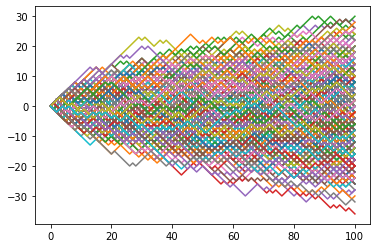

In [5]:
for x in xs:
    plt.plot(np.arange(k+1), x)

#### Snapshots of displacement after $k$ steps follow normal distribution with $\sigma = \sqrt{k}$

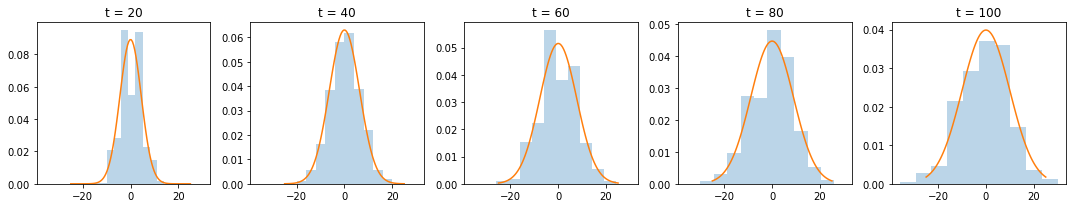

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True)
for i, k in enumerate(range(20, 101, 20)):
    axes[i].hist(xs[:, k], alpha=0.3, density=True)
    axes[i].set_title('t = %d' % k)
    xp = np.linspace(-25, 25, 100)
    axes[i].plot(xp, stats.norm(loc=0, scale=np.sqrt(k)).pdf(xp))
plt.tight_layout()

## Properties of states and Markov chains


A Markov chain is irreducible if it is possible to get from any state to any state. Otherwise it is reducible. 

A state has period $k$ if it must return to that state in multiples of $k$ moves. If $k=1$, the state is aperiodic. If all states are aperiodic, then the Markov chain is aperiodic. 

If any state in an irreducible Markov chain is aperiodic, then all states are aperiodic. 

#### Reducible and aperiodic

A is a transient state. B and C are recurrent states. 

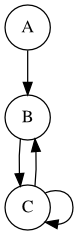

In [7]:
%%dot -p

digraph g {
    node [shape=circle]
    A -> B
    B -> C
    C -> B
    C -> C
}

#### Irreducible and periodic

A, B, and C are recurrent states.

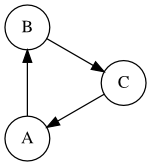

In [8]:
%%dot -p

digraph g {
    layout="circo";
    node [shape=circle]
    A -> B
    B -> C
    C -> A
}

#### Absorbing Markov chain

D is an absorbing state. A, B and C are transient states. Since every state can reach an absorbing state, this is an absorbing Markov chain

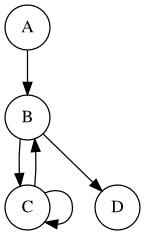

In [9]:
%%dot -p

digraph g {
    node [shape=circle]
    A -> B
    B -> C
    C -> B
    C -> C
    B -> D
}

#### Ergodic

An ergodic state is aperiodic and positive recurrent. If all states are ergodic, then we have an ergodic Markov chain. A finite chain that is aperiodic and irreducible is ergodic.

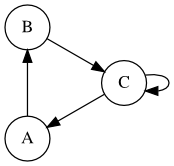

In [10]:
%%dot -p 

digraph g {
    layout="circo";
    node [shape=circle]
    A -> B
    B -> C
    C -> A
    C -> C
}

### Markov Chain

Suppose we have the following transition table:

| Location    | Raleigh | Chapel Hill | Durham |
|:------------|:--------|:------------|:-------|
| Raleigh     | 0.9     | 0.05        | 0.05   |
| Chapel Hill | 0.1     | 0.8         | 0.1    |
| Durham      | 0.04    | 0.01        | 0.95   |

This says that a resident of Raleigh this year has a 90% chance of stying in Raleigh and a 5% chance of relocating to Chapel Hill or Durham the following year. Note that the probabilities only depend on the current year. The transitions between states (Raleigh, Chapel Hill and Durham) are then said to be modeled by a Markov chain. 

If Raleigh, Chapel Hill and Durham each started with 300,000 residents, what is the long run distribution assuming no immigration or emigration?

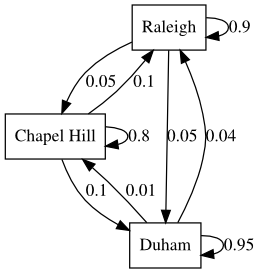

In [11]:
%%dot -p

digraph g {
    node [shape=box]
    R [label="Raleigh"]
    C [label="Chapel Hill"]
    D [label="Duham"]
    R -> R [label=0.9]
    R -> C [label=0.05]
    R -> D [label=0.05]
    C -> R [label=0.1]
    C -> C [label=0.8]
    C -> D [label=0.1]
    D -> R [label=0.04]
    D -> C [label=0.01]
    D -> D [label=0.95]
}

In [12]:
A = np.array([
    [0.9, 0.05, 0.05],
    [0.1, 0.8, 0.1],
    [0.04, 0.01, 0.95]
])

In [13]:
x = np.array([300000, 300000, 300000]).reshape(-1,1)

#### After one year

In [14]:
x.T @ A

array([[312000., 258000., 330000.]])

#### After 2 years

In [15]:
x.T @ A @ A

array([[319800., 225300., 354900.]])

#### Brute force solution

In [16]:
n = 100
x.T @ np.linalg.matrix_power(A, n)

array([[300000.50469469, 100000.21203929, 499999.28326602]])

#### Eigenvector solution

At steady state, we have

$$
p^T A = p^T
$$

Taking the transpose on both sides, we see that

$$
A^Tp = p
$$

suggesting that the steady state probability vector is the normalized eigenvector of $A^T$ with $\lambda = 1$.

In [17]:
E, V = np.linalg.eig(A.T)

In [18]:
E

array([1.        , 0.88520797, 0.76479203])

In [19]:
p = V[:, 2:] / V[:, 2:].sum()
p

array([[-1.20610482e+14],
       [ 1.91384659e+14],
       [-7.07741765e+13]])

In [20]:
p * x.sum()

array([[-1.08549434e+20],
       [ 1.72246193e+20],
       [-6.36967589e+19]])

#### Linear system solution

We cannot solve $A^Tp - p= \mathbb{0}$ directly because $A^T - I$ does not have full rank (since the last column of $A$ is fixed given the other columns).

We need to add the constraint $\sum{p} = 1$ and then we can solve the linear system to find $p$. 

$$
\begin{bmatrix}
(A^T - I) \\
\mathbb{1}^T 
\end{bmatrix} p = \begin{bmatrix}
\mathbb{0} \\
1 \end{bmatrix}
$$

In [21]:
np.linalg.matrix_rank(A.T - np.eye(3))

2

In [22]:
M = np.r_[A.T - np.eye(3), [np.ones(3)]]
b = np.r_[np.zeros(3), 1].reshape(-1,1)

In [23]:
M

array([[-0.1 ,  0.1 ,  0.04],
       [ 0.05, -0.2 ,  0.01],
       [ 0.05,  0.1 , -0.05],
       [ 1.  ,  1.  ,  1.  ]])

In [24]:
b

array([[0.],
       [0.],
       [0.],
       [1.]])

In [25]:
x, res, rank, s = np.linalg.lstsq(M, b, rcond=None)

In [26]:
x

array([[0.33333333],
       [0.11111111],
       [0.55555556]])

### Markov chain averages

We can also consider the perspective of a single individual in terms of the frequencies of places visited.

The individual starts from one of the 3 places (Raleigh, Chapel Hill or Durham) and moves from place to place according to the probabilities in $A$ over a long time. In the long run, the average frequency of visits to a place is the steady state probability of visiting that place.

This suggests that we can estimate the equilibrium or steady state distribution by using the long-run averages, which we'll revisit when we look at Markov chain Monte Carlo (MCMC). Note that the initial averages depend on the starting conditions, so it is common practice to discard some number of the initial iterations (burn-in).

In [27]:
P = np.cumsum(A).reshape(A.shape) - np.array([0,1,2]).reshape(-1,1)
P

array([[0.9 , 0.95, 1.  ],
       [0.1 , 0.9 , 1.  ],
       [0.04, 0.05, 1.  ]])

In [28]:
n = int(1e6)
xs = np.zeros(n+1).astype('int')
xs[0] = np.random.choice([0,1,2])

for t in range(n):
    r = np.random.rand()
    xs[t+1] = np.argmax(r < P[xs[t]])

In [29]:
np.mean(xs==0), np.mean(xs==1), np.mean(xs==2)

(0.3335816664183336, 0.11115588884411115, 0.5552624447375553)